**The next section of the project deals with population data and analysis. Again, I imported here all the modules I used throughout this section.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from datetime import datetime
from IPython.display import display
from matplotlib.ticker import FuncFormatter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

**I again loaded two datasets, both accessed and obtained from the OpenSTAT portal of the Philippine Statistics Authority website. Both datasets are official census numbers coming from the same government agency. In the Philippines, the population census are normally conducted every 5 years. Hence, these datasets are the most comprehensive actual population counts that the public can obtain.**

In [4]:
pop = pd.read_csv("pop.csv") # 2020 census
pop2 = pd.read_csv("pop2.csv") # 2000, 2010, 2015 census

In [5]:
pop.head()

,Province,Total Population
0,Abra,250985
1,Agusan Del Norte,760413
2,Agusan Del Sur,739367
3,Aklan,615475
4,Albay,1374768


In [6]:
pop2.head()

,Province,2000,2010,2015
0,Abra,209491,234733,241160
1,Agusan Del Norte,552849,642196,691566
2,Agusan Del Sur,559294,656418,700653
3,Aklan,451314,535725,574823
4,Albay,1090907,1233432,1314826


**The initial preprocessing steps were simple and straightforward. Both datasets contained only the actual population counts along with their corresponding location names. Since I had already verified that the province names were complete and consistently labeled across both datasets at the time of download, I proceeded with an outer join using the province names as the key. After a quick renaming of the 2020 population column for clarity, the population dataframe named "total" is now ready for analysis.**

In [8]:
total = pd.merge(pop2, pop, on='Province', how='outer')
total.head()

,Province,2000,2010,2015,Total Population
0,Abra,209491,234733,241160,250985
1,Agusan Del Norte,552849,642196,691566,760413
2,Agusan Del Sur,559294,656418,700653,739367
3,Aklan,451314,535725,574823,615475
4,Albay,1090907,1233432,1314826,1374768


In [9]:
total.rename(columns={'Total Population':'2020'}, inplace=True)
total.head()

,Province,2000,2010,2015,2020
0,Abra,209491,234733,241160,250985
1,Agusan Del Norte,552849,642196,691566,760413
2,Agusan Del Sur,559294,656418,700653,739367
3,Aklan,451314,535725,574823,615475
4,Albay,1090907,1233432,1314826,1374768


In [10]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Province  82 non-null     object
 1   2000      82 non-null     int64 
 2   2010      82 non-null     int64 
 3   2015      82 non-null     int64 
 4   2020      82 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 3.3+ KB


**For the purpose of logical chronology, I’ve included this information at this point in the discussion although in reality, I only recognized and resolved the issue after already having created several chart visualizations and conducting substantial background research into Mindanao’s history and political structure.**

**As you can see below, Cotabato province exhibited a steady population increase from 2000 until it showed a suddne decline in the 2020 census. I am aware that population decline is not inherently a red flag or even unusual in population analysis. Urbanization and overall global economic development influence more dynamic migration trends, particularly encouraging emigration from rural areas. However, Cotabato is curiously the only province to exhibit this decline. Upon deeper analysis, I found that Cotabato had a population compounded annual growth rate (CAGR) of over 2% for 15 years before this seemingly abrupt decline in 2020. Note that the annual national CAGR typically hovers in the 1.4-1.7% range and that provinces from Mindanao usually exhibit a faster growth rate relative to the rest of the archipelago. In contrast, the dataset practically implied that the province lost more than 7% of its population in 5 years. For context, Germany's population decline during the Second World War (1939-1945) was estimated to be at 5-6%. This pushed me to do research on Cotabato's history and demographics.**

**It turned out that administrative and geographical mergers and divisions were, and are still, quite common in Mindanao throughout its history. Cotabato itself was previously a very large Moro kingdom before it split into North and South Cotabato in 1966. South Cotabato was also eventually divided again into two current provinces, the other being Sarangani. Meanwhile, the then remaining North Cotabato (which was promptly renamed as Cotabato until its current form) was divided into three provinces in 1973, Maguindanao and Sultan Kudarat being the other two. The most relevant event for this analysis is the decision of 8 municipalities to transfer to a different administrative region. This transfer was a result of a long process but was finalized by the end of 2019. Hence, this was supposed to mean that all government statistics will be handled by the receiving province and region. Interestingly, the population count from these 8 municipalities were not yet added to the receiving province during the 2020 census, i.e. they were kept separate from both their old and new home province, effectively creating a statistical gray area. I then had to make a methodological decision on how to treat these 8 municipalities in the dataset and I eventually chose to retain them under Cotabato province, for the following reasons:**

- **Geographic integrity – The municipalities are still physically within Cotabato’s borders. If I were to build an interactive map, this placement would simplify the mapping process.**
- **Functional alignment – Although the administrative transfer was official on paper, key public services (particularly healthcare) may very well still operate under Cotabato’s system. In relation to the purpose of this project, dengue surveillance and reporting are likely still conducted and routed through Cotabato’s health infrastructure.**
- **Dataset consistency – Keeping the population figures in Cotabato ensures uniformity and continuity in trend analysis.**

**The key consideration in deciding whether to apply the municipality transfer in this dataset is the accuracy and impact of forward population estimates. Ultimately, I decided to reincorporate the numbers to the old province since the transfer is a one-time event, whereas its statistical impact compounds over time. For example, if I leave Cotabato's population unchanged, it will carry over its negative CAGR, which could misleadingly suggest continuous population decline despite such a trend being unlikely in reality. In the same vein, assigning the transferred population to the new province would artificially boost its CAGR, and this inflated growth rate would persist in future projections.**

In [12]:
total[total['Province'] == 'Cotabato']

,Province,2000,2010,2015,2020
25,Cotabato,958643,1226508,1379747,1275185


In [13]:
total.loc[total['Province'] == 'Cotabato', '2020'] = 1490618
total[total['Province'] == 'Cotabato']

,Province,2000,2010,2015,2020
25,Cotabato,958643,1226508,1379747,1490618


**Using the available census data, I estimated the population for non-census years by calculating the CAGR for each adjacent census interval. This allowed me to interpolate values between official counts. To extrapolate population figures beyond 2020, I implemented a weighted CAGR strategy, combining the growth rates from two recent periods: 2015–2020 (weighted at 70%) and 2010–2015 (weighted at 30%). This approach places greater emphasis to the most recent growth trend while still accounting for the historical trajectory of the population.**

**The appropriate CAGR values were applied to fill-in the population counts between census years, as well as projections up to the present year. However, since my dengue case dataset only spans from 2017 to 2024, I limited the population estimates from 2016 to 2025 to align with the epidemiological dataset. These estimates serve as a necessary input for the analysis of dengue incidence later in the project.**

In [15]:
def compute_cagr(start, end, years):
    return ((end / start) ** (1 / years) - 1) * 100

total['cagr00_10'] = compute_cagr(total['2000'], total['2010'], 10).round(2)
total['cagr10_15'] = compute_cagr(total['2010'], total['2015'], 5).round(2)
total['cagr15_20'] = compute_cagr(total['2015'], total['2020'], 5).round(2)

In [16]:
total.head()

,Province,2000,2010,2015,2020,cagr00_10,cagr10_15,cagr15_20
0,Abra,209491,234733,241160,250985,1.14,0.54,0.80
1,Agusan Del Norte,552849,642196,691566,760413,1.51,1.49,1.92
2,Agusan Del Sur,559294,656418,700653,739367,1.61,1.31,1.08
3,Aklan,451314,535725,574823,615475,1.73,1.42,1.38
4,Albay,1090907,1233432,1314826,1374768,1.24,1.29,0.90


In [17]:
total['avgcagr10_20'] = ((total['cagr10_15'] * 0.3) + (total['cagr15_20'] * 0.7)).round(2)

def generate_estimates(row):
    interpolated = {}

    for yr in range(2016, 2021):
        interpolated[f'pop_{yr}'] = round(row['2020'] / ((1 + row['cagr15_20'] / 100) ** (2020 - yr)))
    
    for yr in range(2021, 2026):
        interpolated[f'pop_{yr}'] = round(row['2020'] * ((1 + row['avgcagr10_20'] / 100) ** (yr - 2020)))
    
    return pd.Series(interpolated)

estimates = total.apply(generate_estimates, axis=1)
total = pd.concat([total, estimates], axis=1)

In [18]:
total.drop(columns='pop_2020', inplace=True)
total.head()

,Province,2000,2010,2015,2020,cagr00_10,cagr10_15,cagr15_20,avgcagr10_20,pop_2016,pop_2017,pop_2018,pop_2019,pop_2021,pop_2022,pop_2023,pop_2024,pop_2025
0,Abra,209491,234733,241160,250985,1.14,0.54,0.80,0.72,243112,245056,247017,248993,252792,254612,256445,258292,260152
1,Agusan Del Norte,552849,642196,691566,760413,1.51,1.49,1.92,1.79,704712,718243,732033,746088,774024,787879,801982,816338,830950
2,Agusan Del Sur,559294,656418,700653,739367,1.61,1.31,1.08,1.15,708270,715920,723652,731467,747870,756470,765170,773969,782870
3,Aklan,451314,535725,574823,615475,1.73,1.42,1.38,1.39,582641,590682,598833,607097,624030,632704,641499,650416,659456
4,Albay,1090907,1233432,1314826,1374768,1.24,1.29,0.90,1.02,1326370,1338308,1350352,1362505,1388791,1402956,1417266,1431723,1446326


In [19]:
pop_columns = [col for col in total.columns if col.startswith('pop_') and col[4:].isdigit()]
rename_map = {col: col[4:] for col in pop_columns}
total.rename(columns=rename_map, inplace=True)

years = [str(yr) for yr in range(2000, 2026) if str(yr) in total.columns]
cagrs = [col for col in total.columns if 'cagr' in col and col not in years]

new_order = ['Province'] + years + cagrs
total = total[new_order]
total.head()

,Province,2000,2010,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,cagr00_10,cagr10_15,cagr15_20,avgcagr10_20
0,Abra,209491,234733,241160,243112,245056,247017,248993,250985,252792,254612,256445,258292,260152,1.14,0.54,0.80,0.72
1,Agusan Del Norte,552849,642196,691566,704712,718243,732033,746088,760413,774024,787879,801982,816338,830950,1.51,1.49,1.92,1.79
2,Agusan Del Sur,559294,656418,700653,708270,715920,723652,731467,739367,747870,756470,765170,773969,782870,1.61,1.31,1.08,1.15
3,Aklan,451314,535725,574823,582641,590682,598833,607097,615475,624030,632704,641499,650416,659456,1.73,1.42,1.38,1.39
4,Albay,1090907,1233432,1314826,1326370,1338308,1350352,1362505,1374768,1388791,1402956,1417266,1431723,1446326,1.24,1.29,0.90,1.02


In [20]:
total.to_csv('population.csv', index=False)

**After some column renaming and reorganizing, the population dataset at this point is ready to be integrated with the dengue dataset to allow me to do more meaningful analysis. However, I decided to first explore a few visualization possibilities to identify any potentially interesting insights from the population data itself. Before doing so, I mapped each province to its corresponding major island group (Luzon, Visayas, or Mindanao). This additional layer of categorization may potentially uncover broader spatial patterns or disparities that may not be visible at the provincial level.**

In [22]:
region_group_map = {
    "Luzon": [
        "Abra", "Apayao", "Aurora", "Bataan", "Batangas", "Benguet", "Bulacan", "Cagayan", "Camarines Norte", "Camarines Sur", "Catanduanes", "Cavite", 
        "Ifugao", "Ilocos Norte", "Ilocos Sur", "Isabela", "Kalinga", "La Union", "Laguna", "Mountain Province", "Nueva Ecija", "Nueva Vizcaya", 
        "Occidental Mindoro", "Oriental Mindoro", "Palawan", "Pampanga", "Pangasinan", "Quezon", "Quirino", "Rizal", "Romblon", "Sorsogon", "Tarlac", 
        "Zambales", "NCR", "Masbate", "Albay", "Marinduque", "Batanes"],
    "Visayas": [
        "Aklan", "Antique", "Biliran", "Bohol", "Capiz", "Cebu", "Eastern Samar", "Guimaras", "Iloilo", "Leyte", "Negros Occidental", "Negros Oriental", 
        "Northern Samar", "Samar", "Siquijor", "Southern Leyte"],
    "Mindanao": [
        "Agusan Del Norte", "Agusan Del Sur", "Basilan", "Bukidnon", "Camiguin", "Compostela Valley", "Cotabato", "Davao Del Norte", "Davao Del Sur", 
        "Davao Occidental", "Davao Oriental", "Dinagat Islands", "Lanao Del Norte", "Lanao del Sur", "Maguindanao", "Misamis Occidental", "Misamis Oriental", 
        "Sarangani", "South Cotabato", "Sultan Kudarat", "Sulu", "Surigao Del Norte", "Surigao Del Sur", "Tawi-Tawi", "Zamboanga Del Norte", 
        "Zamboanga Del Sur", "Zamboanga Sibugay", "Davao De Oro", "Lanao Del Sur"]}

def assign_region(province):
    for region, provinces in region_group_map.items():
        if province in provinces:
            return region
    return "Unknown"

In [23]:
total["RegionGroup"] = total["Province"].apply(assign_region)    
total.head()

,Province,2000,2010,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,cagr00_10,cagr10_15,cagr15_20,avgcagr10_20,RegionGroup
0,Abra,209491,234733,241160,243112,245056,247017,248993,250985,252792,254612,256445,258292,260152,1.14,0.54,0.80,0.72,Luzon
1,Agusan Del Norte,552849,642196,691566,704712,718243,732033,746088,760413,774024,787879,801982,816338,830950,1.51,1.49,1.92,1.79,Mindanao
2,Agusan Del Sur,559294,656418,700653,708270,715920,723652,731467,739367,747870,756470,765170,773969,782870,1.61,1.31,1.08,1.15,Mindanao
3,Aklan,451314,535725,574823,582641,590682,598833,607097,615475,624030,632704,641499,650416,659456,1.73,1.42,1.38,1.39,Visayas
4,Albay,1090907,1233432,1314826,1326370,1338308,1350352,1362505,1374768,1388791,1402956,1417266,1431723,1446326,1.24,1.29,0.90,1.02,Luzon


**The first visual is a time series bar chart showing the national population of the Philippines over time. The chart displays actual census data for the years 2000 to 2020, along with the projected estimate for 2025. We can see that the Philippines surpassed the 100 million mark roughly a decade ago and the population has continued to grow steadily since. To put this in perspective, there are currently only 16 countries in the world with populations exceeding 100 million. The most recent country to join this group, Vietnam, crossed the threshold just last year. Another interesting insight is that other reputable sources estimate the current mid-2025 population of the Philippines at approximately 116.8 million. This is already within range of my own computed year-end estimate of about 118 million.**

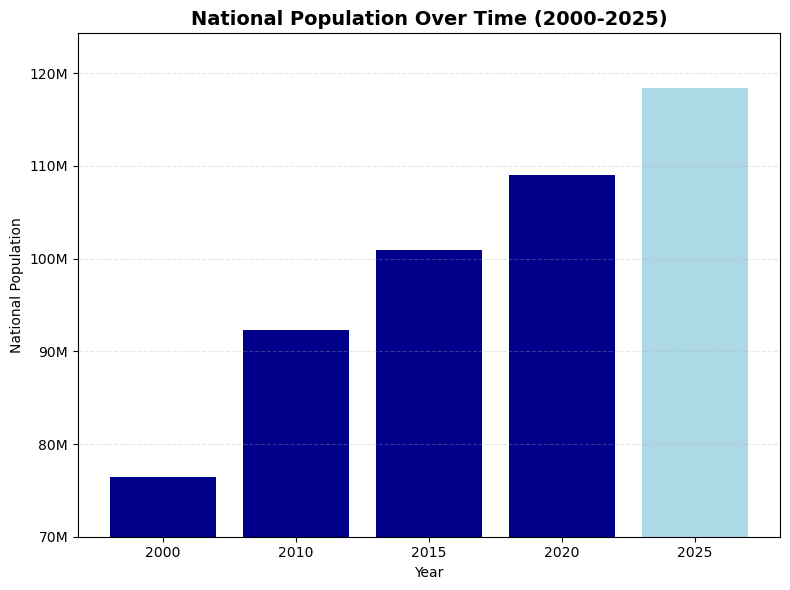

In [25]:
years = ['2000', '2010', '2015', '2020', '2025']
national_population = total[years].sum()

plt.figure(figsize=(8, 6))
bar_colors = ['darkblue'] * (len(years) - 1) + ['lightblue']
plt.bar(national_population.index, national_population.values, color=bar_colors)
plt.ylim(bottom=70_000_000)
formatter = FuncFormatter(lambda x, _: f'{int(x) // 1_000_000}M')
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlabel('Year')
plt.ylabel('National Population')
plt.title('National Population Over Time (2000-2025)', fontsize=14, fontweight='bold')
plt.gca().xaxis.grid(False) 
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**When broken down by major island groups, Luzon — which geographically includes NCR — houses more than half of the country’s population. The capital region alone has a population roughly equivalent to half that of Mindanao, the second-largest island group in the Philippines.**

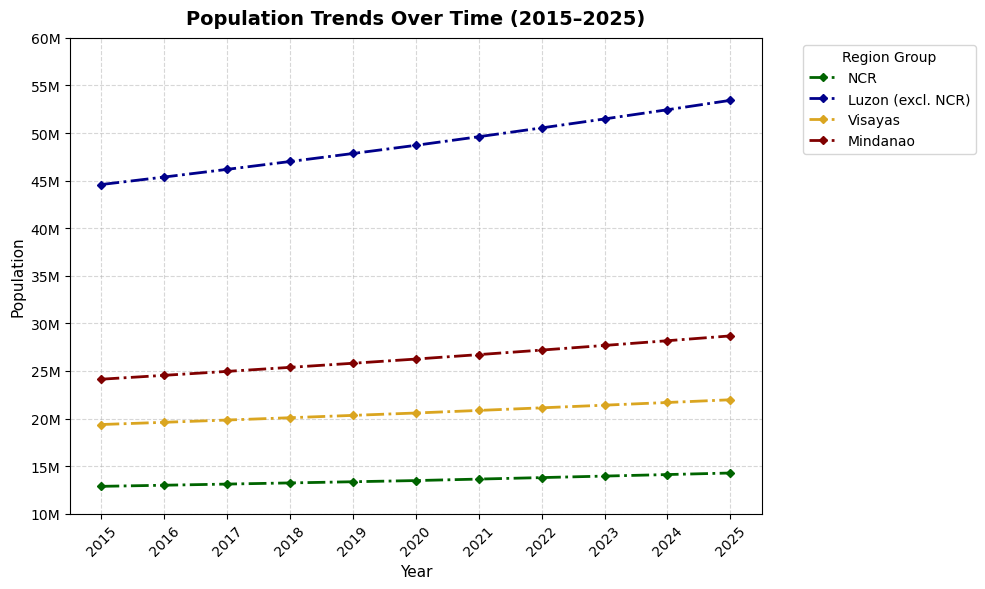

In [27]:
year_cols = [str(y) for y in range(2015, 2026)]
ncr_data = total[total["Province"] == "NCR"][year_cols].sum()
luzon_data = total[(total["RegionGroup"] == "Luzon") & (total["Province"] != "NCR")][year_cols].sum()
visayas_data = total[total["RegionGroup"] == "Visayas"][year_cols].sum()
mindanao_data = total[total["RegionGroup"] == "Mindanao"][year_cols].sum()
colors = {"NCR":"darkgreen", "Luzon (excl. NCR)":"darkblue", "Visayas":"goldenrod", "Mindanao":"maroon"}

pop_over_time = pd.DataFrame({"NCR":ncr_data, "Luzon (excl. NCR)":luzon_data, "Visayas":visayas_data, "Mindanao":mindanao_data})

fig, ax = plt.subplots(figsize=(10, 6))
for region, series in pop_over_time.items():
    ax.plot(year_cols, series.values, label=region, linewidth=2, linestyle='-.', marker='D', markersize=4, color=colors[region])

ticks = ax.get_yticks()
ax.set_yticks(ticks)
ax.set_yticklabels([f'{int(t/1_000_000)}M' for t in ticks])
ax.set_title("Population Trends Over Time (2015–2025)", fontsize=14, weight='bold', pad=10)
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Population", fontsize=11)
plt.xticks(rotation=45)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(title="Region Group", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

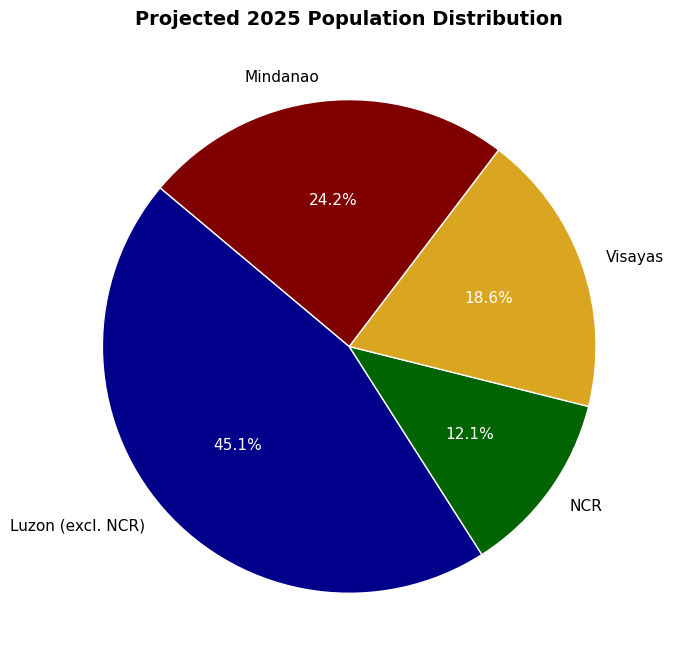

In [28]:
ncr_2025 = total[total["Province"] == "NCR"]["2025"].sum()
luzon_2025 = total[(total["RegionGroup"] == "Luzon") & (total["Province"] != "NCR")]["2025"].sum()
visayas_2025 = total[total["RegionGroup"] == "Visayas"]["2025"].sum()
mindanao_2025 = total[total["RegionGroup"] == "Mindanao"]["2025"].sum()

group_labels = ["Luzon (excl. NCR)", "NCR", "Visayas", "Mindanao"]
group_sizes = [luzon_2025, ncr_2025, visayas_2025, mindanao_2025]
colors = ["darkblue", "darkgreen", "goldenrod", "maroon"]

fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(group_sizes, labels=group_labels, autopct='%1.1f%%', startangle=140, 
                                  colors=colors, textprops={'fontsize': 11}, wedgeprops={'edgecolor': 'white', 'linewidth': 1})

for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('white')
    
plt.title("Projected 2025 Population Distribution", fontsize=14, weight='bold', pad=10)
plt.tight_layout()
plt.show()

**I then created an interactive bar chart tracking the 15 most populous provinces in the last 10 years. We can see that over the past decade, the large metropolises of NCR and Cebu have consistently been the two most populous areas in the country, reflecting their importance as major economic and urban centers in the country. By the last population census in 2020, the next four most populous provinces are those surrounding NCR, forming the core of the Greater Manila Area megapolis. This highlights the ongoing urban sprawl in these adjacent provinces. By the end of 2025, 10 out of the country's 82 provinces are expected to have more than 3 million residents. Also, three provinces from the Visayas region — Cebu, Negros Occidental, and Iloilo — are projected to rank among the top 15. Notably, 23 out of 39 cities in the Visayas, including 5 of its 7 Highly Urbanized Cities, are located within these provinces. In Mindanao, Davao del Sur is the lone representative in the top 15, anchored by Davao City, which is the island's largest city in terms of population, land area, and economic activity.**

In [30]:
years = list(map(str, range(2015, 2026)))
pop_cols = ['Province'] + [col for col in years if col in total.columns]
df = total[pop_cols].copy()

df_long = df.melt(id_vars='Province', var_name='Year', value_name='Population')
df_long['Year'] = df_long['Year'].astype(int)
df_long = df_long[df_long['Year'].between(2015, 2025)]

top15_list = []
for year, group in df_long.groupby('Year'):
    top15 = group.nlargest(15, 'Population')
    top15_list.append(top15)
top15_per_year = pd.concat(top15_list).reset_index(drop=True)

category_orders_per_year = {year: list(group.sort_values('Population', ascending=True)['Province']) for year, group in top15_per_year.groupby('Year')}

fig = px.bar(top15_per_year, x='Population', y='Province', color='Province', animation_frame='Year', orientation='h', height=700, width=1200,
    range_x=[0, top15_per_year['Population'].max() * 1.1], title='Most Populated Philippine Provinces Over Time (2015–2025)',)

fig.update_layout(title=dict(text='Most Populated Philippine Provinces Over Time (2015–2025)', font=dict(size=18, color='black', weight='bold'), 
    x=0.5, xanchor='center'), margin=dict(t=30), xaxis_title='Population', yaxis_title='Province', showlegend=False,
    updatemenus=[{"type": "buttons",
        "buttons": [
            {"label":"Play", "method":"animate","args":[None, {"frame":{"duration":1000, "redraw":True},
                             "transition":{"duration":1000, "easing":"linear"}, "fromcurrent":True, "mode":"immediate"}]},
            {"label":"Pause", "method":"animate", "args":[[None],{"frame":{"duration":0}, "mode":"immediate"}]}]}])

for frame in fig.frames:
    year = int(frame.name)
    if year in category_orders_per_year:
        frame.layout.yaxis.categoryarray = category_orders_per_year[year]

first_year = top15_per_year['Year'].min()
fig.layout.yaxis.categoryarray = category_orders_per_year[first_year]
fig.show()

**Having fun with the previous visual, I created another interactive chart. This chart extends the population projections through 2035 by applying the weighted CAGR of each province. While the precision and reliability of projections naturally decline the further we look ahead, this chart provides a visually compelling way to explore how population patterns in different provinces might evolve assuming current trends continue at a steady pace.**

In [32]:
pop_years = [str(y) for y in range(2015, 2026)]
forecast_years = [str(y) for y in range(2026, 2036)]

national_pop = total[pop_years].sum()
national_cagr = np.average(total['avgcagr10_20'], weights=total['2020'])

national_row = pd.Series({'Province': 'Philippines', 'avgcagr10_20': national_cagr})
for year in pop_years:
    national_row[year] = national_pop[year]
total_all = pd.concat([total.copy(), pd.DataFrame([national_row])], ignore_index=True)

for idx, row in total_all.iterrows():
    cagr = row['avgcagr10_20'] / 100
    last_pop = row['2025']
    for year in forecast_years:
        last_pop *= (1 + cagr)
        total_all.at[idx, str(year)] = last_pop

provinces = total_all['Province'].tolist()
provinces.remove('Philippines')
province_list = ['None', 'Philippines'] + provinces

def plot_population(p1, p2, p3, p4, p5):
    selected = [p for p in [p1, p2, p3, p4, p5] if p != 'None']
    fig = go.Figure()
    colors = px.colors.qualitative.Plotly

    for i, province in enumerate(selected):
        row = total_all[total_all['Province'] == province].iloc[0]
        color = colors[i % len(colors)]

        y_actual = row[pop_years].astype(float)
        y_forecast = row[forecast_years].astype(float)

        fig.add_trace(go.Scatter(x=pop_years, y=y_actual, mode='lines+markers', name=province, line=dict(color=color)))
        fig.add_trace(go.Scatter(x=['2025', '2026'], y=[y_actual['2025'], y_forecast['2026']], mode='lines',
                                 line=dict(color=color, dash='dot'), showlegend=False))
        fig.add_trace(go.Scatter(x=forecast_years, y=y_forecast, mode='lines', line=dict(color=color, dash='dash'), showlegend=False))

    fig.update_layout(
        title=dict(text='Population Growth Projections (2015–2035)', font=dict(size=18, color='black', weight='bold'), y=0.99),
        xaxis_title='Year',
        yaxis_title='Population',
        xaxis_tickangle=270,
        template='plotly_white',
        height=650,
        width=950,
        margin=dict(t=90, r=0, b=60, l=60),
        legend=dict(x=1.02, y=0, xanchor='left', yanchor='bottom', bgcolor='rgba(255,255,255,0)', bordercolor='LightGrey', borderwidth=1))

    fig.show()

dropdowns = [widgets.Dropdown(options=province_list, description='Province:', layout=widgets.Layout(width='250px')) for _ in range(5)]
control_box = widgets.VBox(dropdowns, layout=widgets.Layout(width='260px'))
plot_output = widgets.interactive_output(plot_population, {'p1':dropdowns[0], 'p2':dropdowns[1], 'p3':dropdowns[2], 'p4':dropdowns[3], 'p5':dropdowns[4]})
display(widgets.HBox([plot_output, control_box]))

**Next, I tried to explore the dynamics between population size and growth. Here we can see a fairly balanced distribution of both fast- and slow-growing provinces, regardless of their current population size. Notably, despite being the most populous, the National Capital Region has a growth rate well below the national average. In contrast, its surrounding suburban provinces appear poised for accelerated growth in the near future, possibly driven by continued urban sprawl and futher urbanization. Another striking insight are the two provinces in Mindanao that are posting nearly 4% annual growth rate. Both currently have modest populations but their sustained growth could signal a shift in regional development patterns. Whether these provinces evolve into future urban centers remains to be seen, but the trend could be worth watching.**

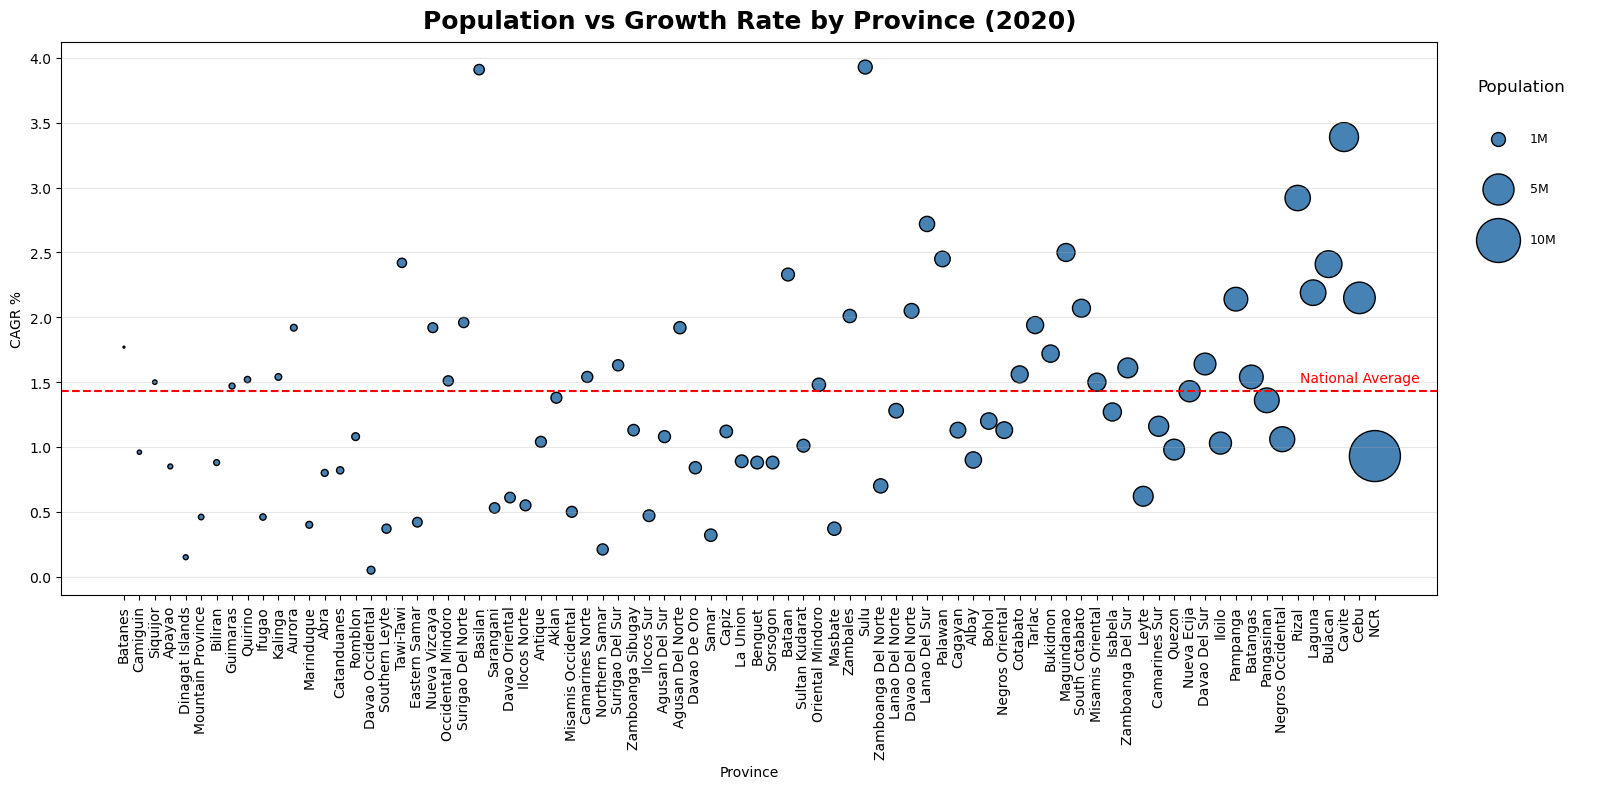

In [34]:
sorted2020 = total.sort_values('2020')

plt.figure(figsize=(16, 8))
plt.scatter(sorted2020['Province'], sorted2020['cagr15_20'], s=sorted2020['2020'] / 10000, alpha=1, color='steelblue', edgecolors='black', linewidth=1)
plt.xticks(ticks=range(len(sorted2020)), labels=sorted2020['Province'], rotation=90, ha='center')
plt.xlabel('Province')
plt.ylabel('CAGR %')
plt.title('Population vs Growth Rate by Province (2020)', fontsize=18, fontweight='bold', pad=10)

national_avg = 1.43
plt.axhline(y=national_avg, color='red', linestyle='--', linewidth=1.5)
plt.text(len(sorted2020) - 2, national_avg + 0.05, 'National Average', color='red', ha='center', va='bottom', fontsize=10)

pop_sizes = [1_000_000, 5_000_000, 10_000_000]
legend_handles = [plt.scatter([], [], s=size / 10000, color='steelblue', edgecolors='black') for size in pop_sizes]
legend_labels = [f'{size // 1_000_000}M' for size in pop_sizes]

plt.legend(legend_handles, legend_labels, title="Population", loc='upper right', bbox_to_anchor=(1.12, 1), 
           fontsize=9, title_fontsize=12, labelspacing=3, handletextpad=1.5, borderpad=2.5, frameon=False)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

**To further explore the population size vs growth rate story and to practice a bit of statistics, I ran a quick correlation analysis. As expected, the result confirmed a near-zero R-squared value, indicating virtually no linear relationship between the two. In other words, provinces with large populations do not necessarily grow faster, and those experiencing rapid growth are not always highly populated. This showcases the diversity of demographic patterns across the country where growth is influenced by factors beyond size alone.**

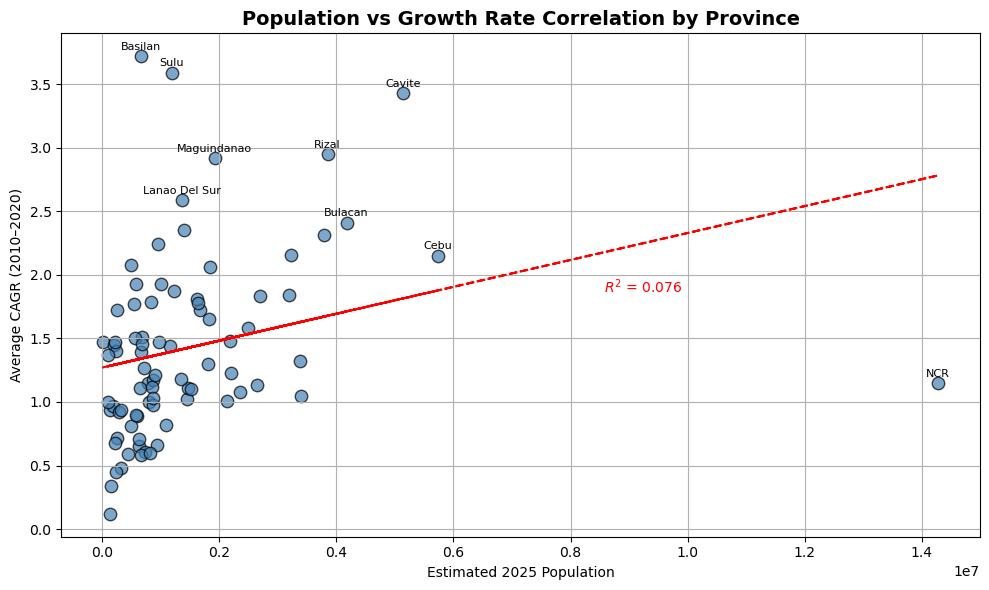

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(total['2025'], total['avgcagr10_20'], alpha=0.7, c='steelblue', edgecolors='black', s=80)
plt.xlabel('Estimated 2025 Population')
plt.ylabel('Average CAGR (2010–2020)')
plt.title('Population vs Growth Rate Correlation by Province', fontsize=14, weight='bold')

for i, row in total.iterrows():
    if row['2025'] > 4000000 or row['avgcagr10_20'] > 2.5:
        plt.text(row['2025'], row['avgcagr10_20'] + 0.05, row['Province'], fontsize=8, ha='center')

z = np.polyfit(total['2025'], total['avgcagr10_20'], 1)
p = np.poly1d(z)
plt.plot(total['2025'], p(total['2025']), "r--")

corr_matrix = np.corrcoef(total['2025'], total['avgcagr10_20'])
r_squared = corr_matrix[0, 1]**2
plt.text(total['2025'].max()*0.6, total['avgcagr10_20'].max() * 0.5, f'$R^2$ = {r_squared:.3f}', fontsize=10, color='red')

plt.grid(True)
plt.tight_layout()
plt.show()

**I re-ran the analysis excluding NCR since the magnitude of its population size was acting as a significant outlier in the initial trial. Even then, the results continued to show a weak correlation between population size and growth rate.**

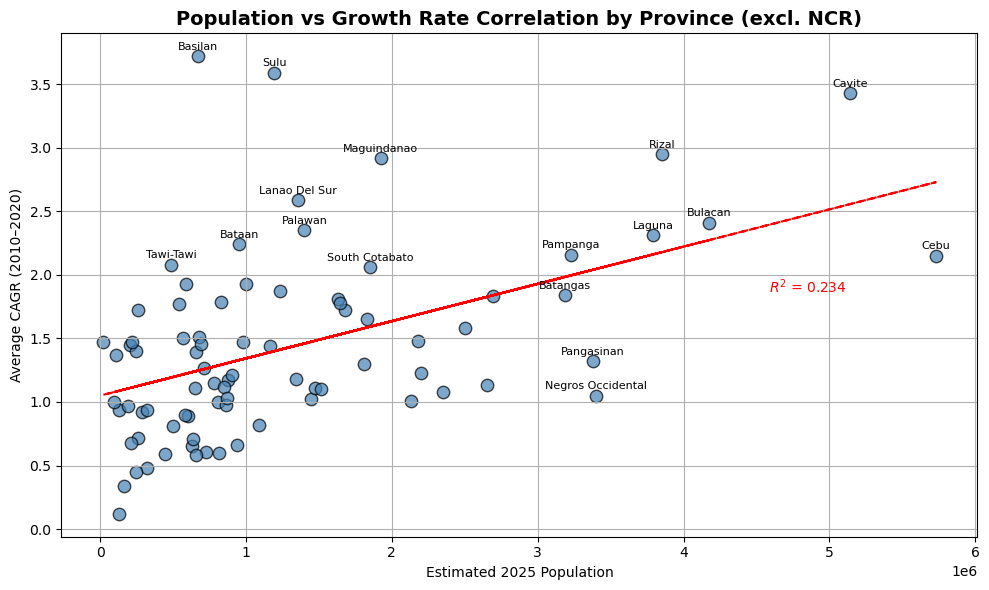

In [38]:
filtered = total[total['Province'] != 'NCR']

plt.figure(figsize=(10, 6))
plt.scatter(filtered['2025'], filtered['avgcagr10_20'], alpha=0.7, c='steelblue', edgecolors='black', s=80)
plt.xlabel('Estimated 2025 Population')
plt.ylabel('Average CAGR (2010–2020)')
plt.title('Population vs Growth Rate Correlation by Province (excl. NCR)', fontsize=14, weight='bold')

for i, row in filtered.iterrows():
    if row['2025'] > 3000000 or row['avgcagr10_20'] > 2 or row['avgcagr10_20'] < 0:
        plt.text(row['2025'], row['avgcagr10_20'] + 0.05, row['Province'], fontsize=8, ha='center')

z = np.polyfit(filtered['2025'], filtered['avgcagr10_20'], 1)
p = np.poly1d(z)
plt.plot(filtered['2025'], p(filtered['2025']), "r--")

corr_matrix = np.corrcoef(filtered['2025'], filtered['avgcagr10_20'])
r_squared = corr_matrix[0, 1]**2
plt.text(filtered['2025'].max() * 0.8, filtered['avgcagr10_20'].max() * 0.5, f'$R^2$ = {r_squared:.3f}', fontsize=10, color='red')

plt.grid(True)
plt.tight_layout()
plt.show()

**I also tried to run a polynomial regression model to check if a nonlinear approach would result to a better fit. However, the results barely changed.**

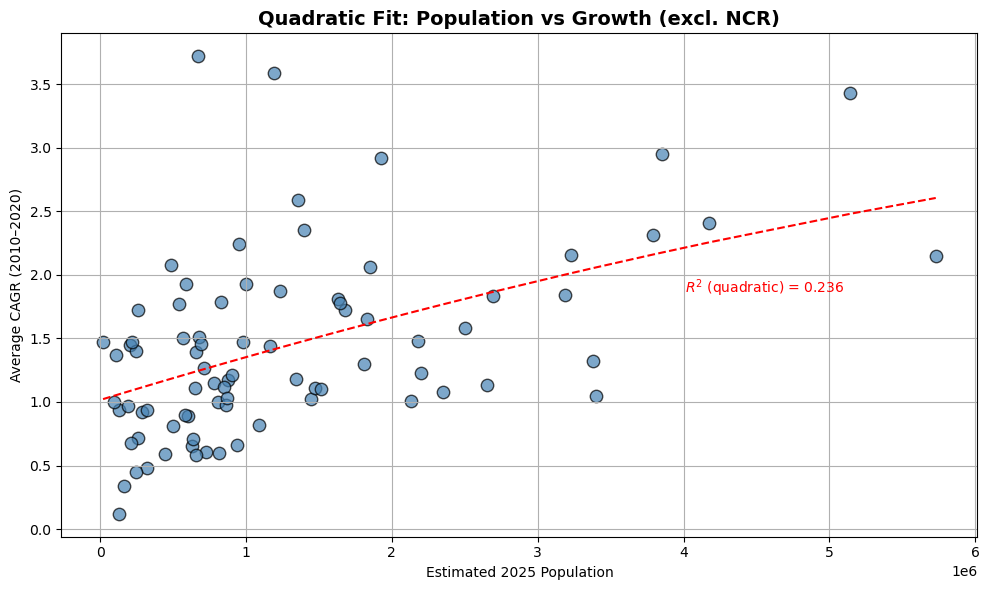

In [40]:
filtered = total[total['Province'] != 'NCR']

plt.figure(figsize=(10, 6))
plt.scatter(filtered['2025'], filtered['avgcagr10_20'], alpha=0.7, c='steelblue', edgecolors='black', s=80)
plt.xlabel('Estimated 2025 Population')
plt.ylabel('Average CAGR (2010–2020)')
plt.title('Quadratic Fit: Population vs Growth (excl. NCR)', fontsize=14, weight='bold')

z = np.polyfit(filtered['2025'], filtered['avgcagr10_20'], 2)
p = np.poly1d(z)
plt.plot(np.sort(filtered['2025']), p(np.sort(filtered['2025'])), "r--")

y_hat = p(filtered['2025'])
y = filtered['avgcagr10_20']
residuals = y - y_hat
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_poly = 1 - (ss_res / ss_tot)

plt.text(filtered['2025'].max() * 0.7, filtered['avgcagr10_20'].max() * 0.5, f'$R^2$ (quadratic) = {r_squared_poly:.3f}', fontsize=10, color='red')

plt.grid(True)
plt.tight_layout()
plt.show()

**Diving even deeper out of curiosity, I extended the regression analysis to a 10th-degree polynomial to see if a more complex model could reveal a stronger relationship between population size and growth rate. Even at this high level of model complexity, the results still demonstrated only a weak positive correlation between the two variables.**

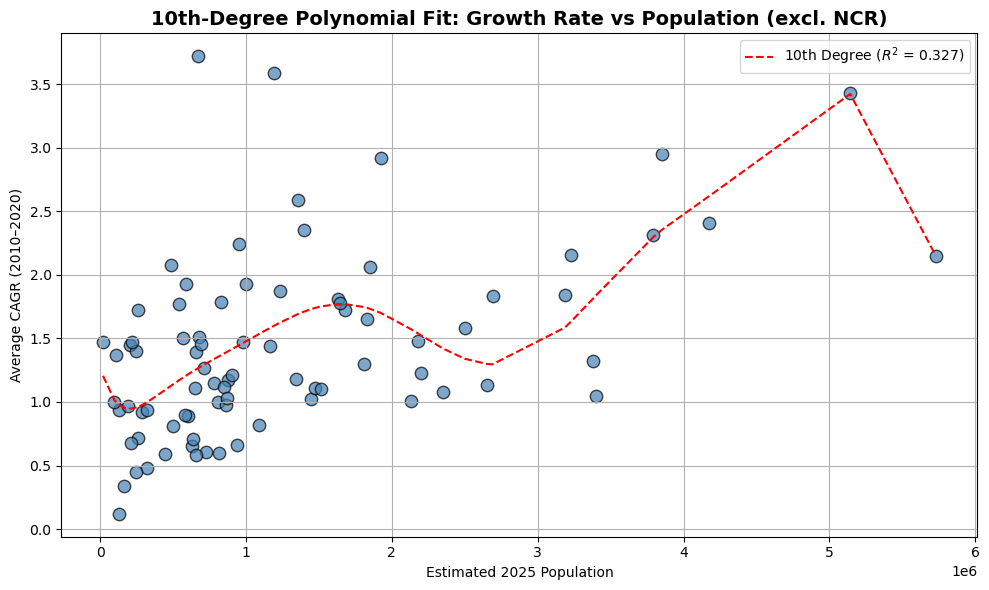

In [42]:
filtered = total[total['Province'] != 'NCR']
x = filtered['2025'] 
y = filtered['avgcagr10_20']

z = np.polyfit(x, y, 10)
p = np.poly1d(z)

y_hat = p(x)
ss_res = np.sum((y - y_hat)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_10 = 1 - (ss_res / ss_tot)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7, c='steelblue', edgecolors='black', s=80)
plt.plot(np.sort(x), p(np.sort(x)), "r--", label=f'10th Degree ($R^2$ = {r_squared_10:.3f})')

plt.xlabel('Estimated 2025 Population')
plt.ylabel('Average CAGR (2010–2020)') 
plt.title('10th-Degree Polynomial Fit: Growth Rate vs Population (excl. NCR)', fontsize=14, weight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Finally, to extract relevant and real-world insights from the population size vs. growth story, I applied K-means clustering to group provinces exhibiting similar demographic dynamics. After testing different configurations of n_clusters ranging from 2 to 5, I decided that a 3-cluster model offered the most reasonable segmentation. The algorithm appeared to delineate provinces around key marks of 2.5 million population and/or 1.5% annual growth rate. Based on the observed clustering, I personally labeled them as follows:**

- **Metro Hubs: these are provinces with populations exceeding 2.5 million. These include the Greater Manila Area and its peripheral provinces (Batangas, Pampanga, Pangasinan, and Nueva Ecija) as well as provinces that house major highly-urbanized cities such as Cebu (Cebu City), Iloilo (Iloilo City), Davao del Sur (Davao City), and Negros Occidental (Bacolod City).**
- **Emerging Provinces: these are generally under 2 million in population but growing at a rate above 1.5% annually. Notably, 13 out of the 19 provinces in this cluster are located in Mindanao, potentially suggesting hotspots for future urban and economic development.**
- **Stable Rural: this is the largest cluster, comprised of 50 out of the 82 Philippines provinces. These areas typically have lower population growth and are largely agricultural, with limited road infrastructure and industrial activity. The sheer number of provinces in this cluster strongly indicates that the Philippines remains to be a predominantly rural and agricultural country and may continue to be so in the forseeable future.**

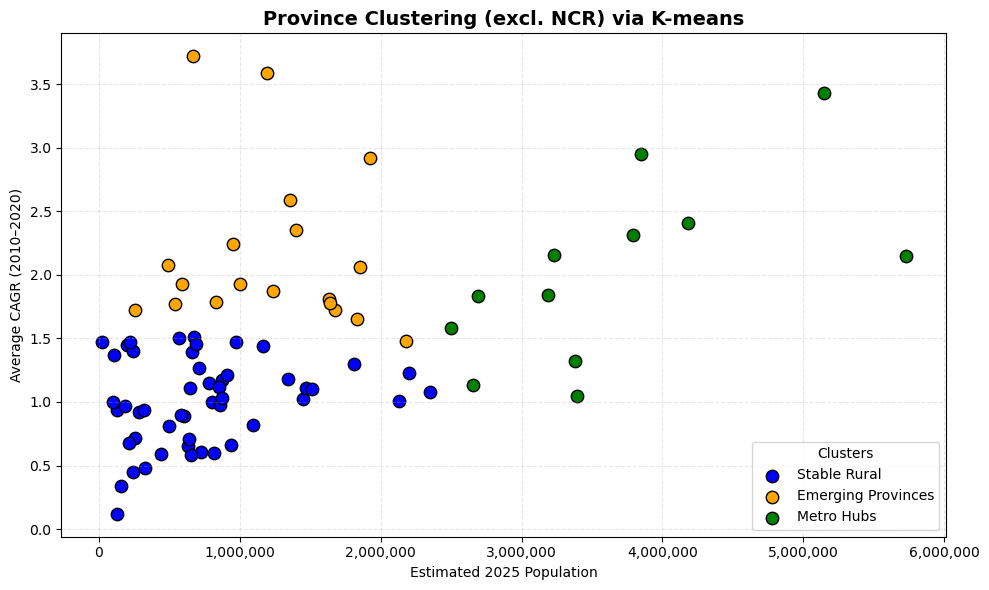

In [44]:
filtered = filtered.copy()
X = filtered[['avgcagr10_20', '2025']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
filtered.loc[:, 'Cluster'] = kmeans.fit_predict(X_scaled)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X.columns)
centers['Cluster'] = centers.index
centers = centers.sort_values(by=['2025', 'avgcagr10_20'], ascending=True).reset_index(drop=True)

label_map = dict(zip(centers['Cluster'], ['Stable Rural', 'Emerging Provinces', 'Metro Hubs']))
filtered['ClusterLabel'] = filtered['Cluster'].map(label_map)
colors = {'Stable Rural':'blue', 'Emerging Provinces':'orange', 'Metro Hubs':'green'}

plt.figure(figsize=(10, 6))
for label, color in colors.items():
    subset = filtered[filtered['ClusterLabel'] == label]
    plt.scatter(subset['2025'], subset['avgcagr10_20'], label=label, s=80, edgecolors='black', color=color)
plt.xlabel('Estimated 2025 Population')
plt.ylabel('Average CAGR (2010–2020)')
plt.title('Province Clustering (excl. NCR) via K-means', fontsize=14, fontweight='bold')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.legend(title='Clusters')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
final_labels = ['Stable Rural', 'Emerging Provinces', 'Metro Hubs']
for label in final_labels:
    provinces = filtered[filtered['ClusterLabel'] == label]['Province'].tolist()
    print(f"\n {label} ({len(provinces)} provinces):")
    for prov in provinces:
        print(f" - {prov}")


 Stable Rural (50 provinces):
 - Abra
 - Agusan Del Sur
 - Aklan
 - Albay
 - Antique
 - Apayao
 - Batanes
 - Benguet
 - Biliran
 - Bohol
 - Cagayan
 - Camarines Norte
 - Camarines Sur
 - Camiguin
 - Capiz
 - Catanduanes
 - Davao De Oro
 - Davao Occidental
 - Davao Oriental
 - Dinagat Islands
 - Eastern Samar
 - Guimaras
 - Ifugao
 - Ilocos Norte
 - Ilocos Sur
 - Isabela
 - Kalinga
 - La Union
 - Lanao Del Norte
 - Leyte
 - Marinduque
 - Masbate
 - Misamis Occidental
 - Mountain Province
 - Negros Oriental
 - Northern Samar
 - Occidental Mindoro
 - Oriental Mindoro
 - Quezon
 - Quirino
 - Romblon
 - Samar
 - Sarangani
 - Siquijor
 - Sorsogon
 - Southern Leyte
 - Sultan Kudarat
 - Surigao Del Sur
 - Zamboanga Del Norte
 - Zamboanga Sibugay

 Emerging Provinces (19 provinces):
 - Agusan Del Norte
 - Aurora
 - Basilan
 - Bataan
 - Bukidnon
 - Cotabato
 - Davao Del Norte
 - Lanao Del Sur
 - Maguindanao
 - Misamis Oriental
 - Nueva Vizcaya
 - Palawan
 - South Cotabato
 - Sulu
 - Surigao Del